# LiNbO Samples

## Test of Extractor class on reflection data (LiNbO @ 489 µm)

In [1]:
from utils import move_to_thz_tds_directory
move_to_thz_tds_directory()

Success! Current directory is now: /Users/theosmith/Documents/MPhys_YiER_Project/Git_repo/THz-TDS


In [2]:
from Extraction.Extractor import Extractor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
ref_tab = pd.read_csv("Data_sets/complex_data/ref2.pulse.csv").to_numpy()
sample_tab = pd.read_csv("Data_sets/complex_data/LiNbO-2-489.pulse.csv").to_numpy()

In [4]:
extractor = Extractor(ref_tab, sample_tab, thickness=489 * 1e-6)

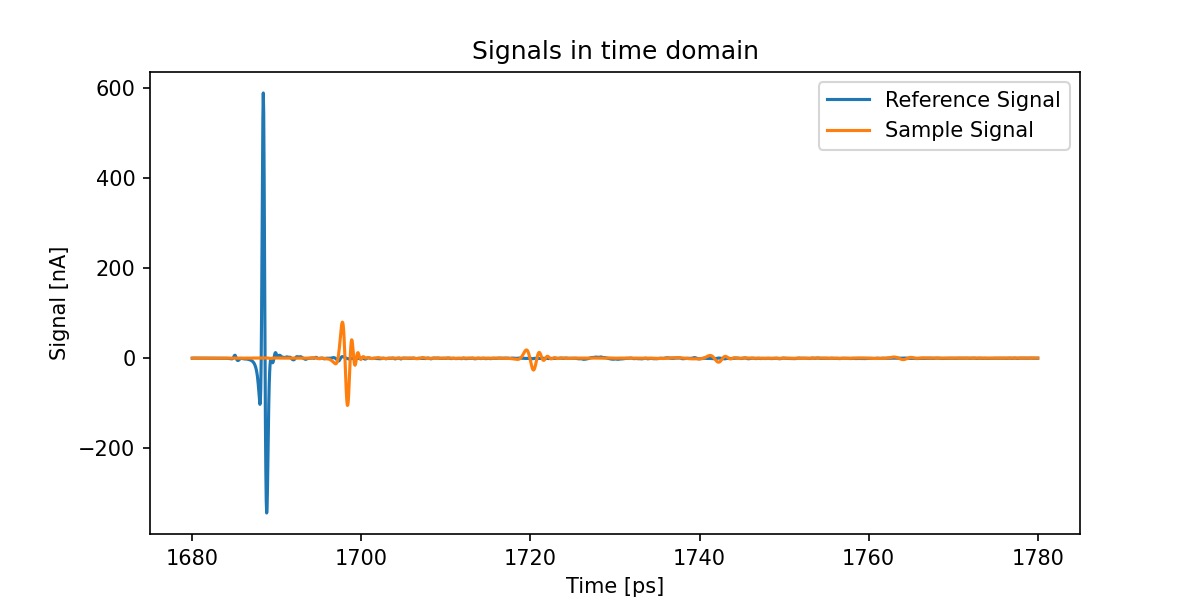

In [5]:
extractor.plot_time_domain()

In [6]:
extractor.fft_signals()

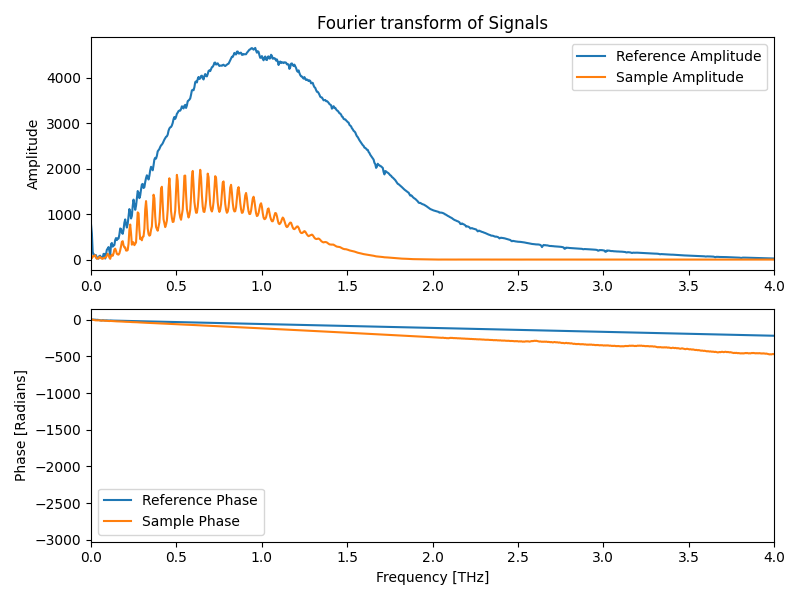

In [7]:
extractor.plot_frequency_domain()

# This demonstates the Etalon effect in the fft of the sample (wavy pattern at 0-1.5 THz)

/Users/theosmith/Documents/MPhys_YiER_Project/Git_repo/THz-TDS/Extraction/transfer_functions.py:23: RuntimeWarning: overflow encountered in exp
  return (4 * n) / ((n + 1) ** 2) * np.exp(-1j * (n - 1) * w * length/ c)
/Users/theosmith/Documents/MPhys_YiER_Project/Git_repo/THz-TDS/Extraction/transfer_functions.py:23: RuntimeWarning: invalid value encountered in multiply
  return (4 * n) / ((n + 1) ** 2) * np.exp(-1j * (n - 1) * w * length/ c)


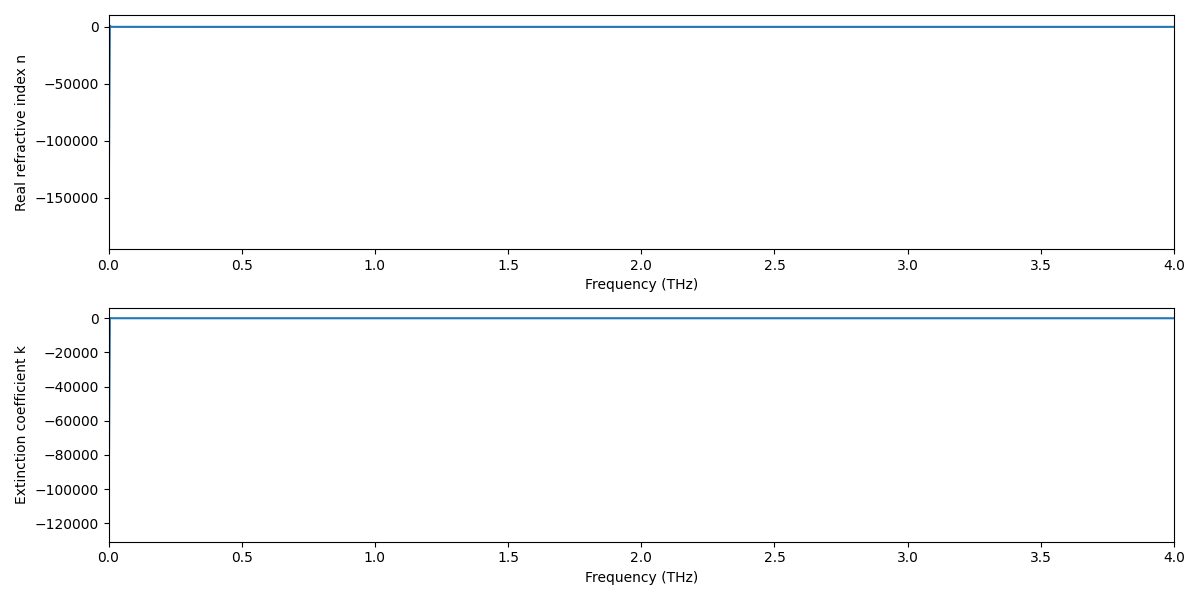

In [8]:
extractor.calculate_refractive_index(n_0=6.7 + 0.1j)
extractor.plot_refractive_index()

## Application of Windowing to LiNbO @ 489 µm

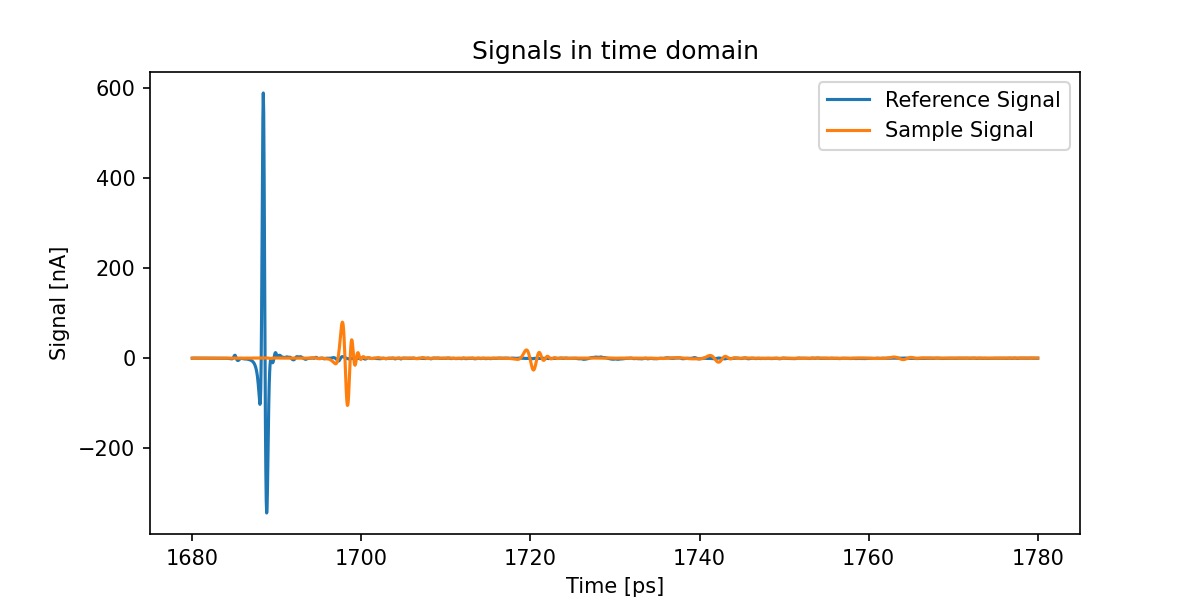

In [9]:
# Reload the data
ref_tab = None
sample_tab = None

ref_tab = pd.read_csv("Data_sets/complex_data/ref2.pulse.csv").to_numpy()
sample_tab = pd.read_csv("Data_sets/complex_data/LiNbO-2-489.pulse.csv").to_numpy()

# Extract the signals and time data
signal_ref = ref_tab[:, 1]
signal_sample = sample_tab[:, 1]

time_ref = ref_tab[:, 0]
time_sample = sample_tab[:, 0]

# Calculate offset and padding
offset = time_sample[0] - time_ref[0]
time_step = time_ref[1] - time_ref[0]
n_padding = int(offset / time_step)

# Adjust time and signal arrays by padding
time_ref = np.concatenate([time_ref, np.linspace(time_ref[-1], time_sample[-1], n_padding)])
time_sample = np.concatenate([np.linspace(time_ref[0], time_sample[0], n_padding), time_sample])
signal_ref = np.concatenate([signal_ref, np.zeros(n_padding)])
signal_sample = np.concatenate([np.zeros(n_padding), signal_sample])

# Time and frequency domain parameters
T = time_step
Fs = 1 / T
L = len(signal_ref)
t = np.arange(0, L) * T
f = Fs / L * np.arange(0, L)    # Frequency values

# Plot the signals
plt.figure(figsize=(8,4),dpi=150)
plt.plot(time_ref, signal_ref, label="Reference Signal")
plt.plot(time_sample, signal_sample, label="Sample Signal")
plt.title('Signals in time domain')
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

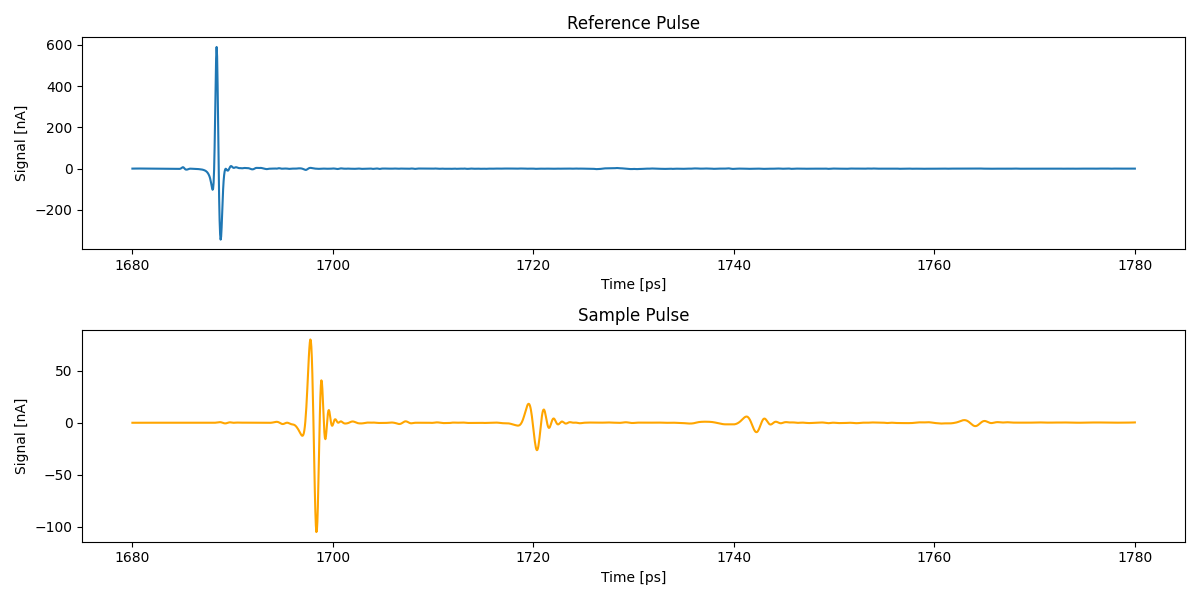

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

# Plot real part of refractive index
axs[0].plot(time_ref, signal_ref, label="Reference Signal")
axs[0].set_xlabel("Time [ps]")
axs[0].set_ylabel("Signal [nA]")
axs[0].set_title("Reference Pulse")

# Plot imaginary part of refractive index (extinction coefficient)
axs[1].plot(time_sample, signal_sample, c='orange',label="Sample Signal")
axs[1].set_xlabel("Time [ps]")
axs[1].set_ylabel("Signal [nA]")
axs[1].set_title("Sample Pulse")

# Display the plots
plt.tight_layout()
plt.show()

### Apply Windowing

In [11]:
from scipy.signal.windows import tukey

In [12]:
## derive "automatic" window fitting method by locating peak and centering the window on that

# locate index of maximum point on the pulses
window_centre_index_ref = np.argmax(np.abs(signal_ref))
window_centre_index_sample= np.argmax(np.abs(signal_sample))

window_half_width = 150

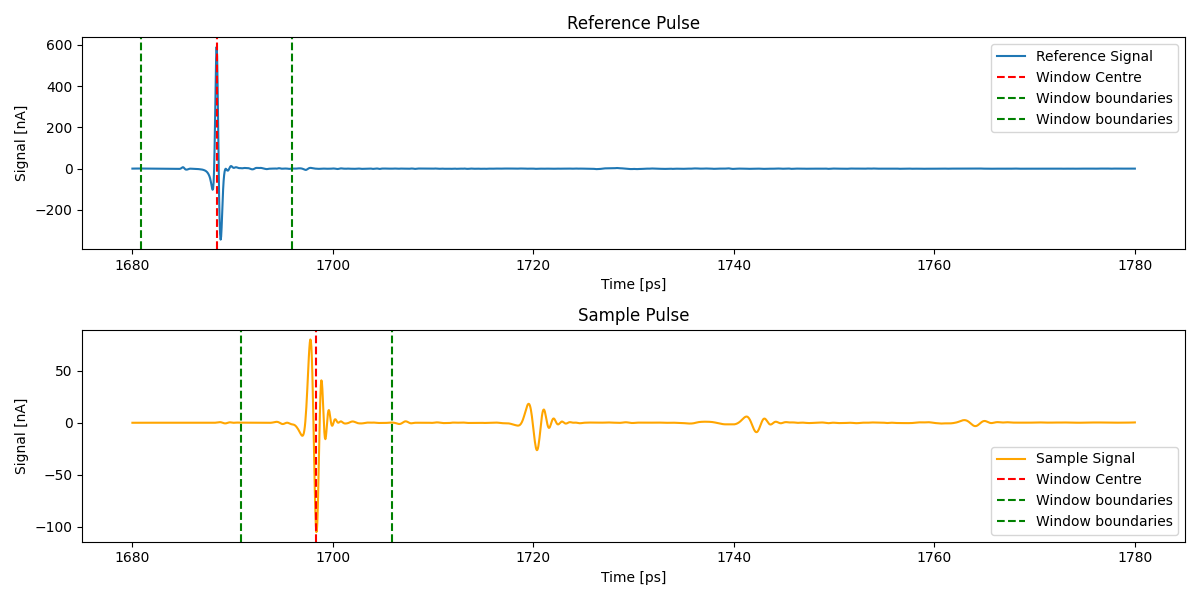

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

# Plot real part of refractive index
axs[0].plot(time_ref, signal_ref, label="Reference Signal")
axs[0].axvline(x=time_ref[window_centre_index_ref], color='r', linestyle='--', label='Window Centre')
axs[0].axvline(x=time_ref[window_centre_index_ref - window_half_width], color='g', linestyle='--', label='Window boundaries')
axs[0].axvline(x=time_ref[window_centre_index_ref + window_half_width], color='g', linestyle='--', label='Window boundaries')
axs[0].set_xlabel("Time [ps]")
axs[0].set_ylabel("Signal [nA]")
axs[0].set_title("Reference Pulse")
axs[0].legend()

# Plot imaginary part of refractive index (extinction coefficient)
axs[1].plot(time_sample, signal_sample, c='orange',label="Sample Signal")
axs[1].axvline(x=time_sample[window_centre_index_sample], color='r', linestyle='--', label='Window Centre')
axs[1].axvline(x=time_sample[window_centre_index_sample - window_half_width], color='g', linestyle='--', label='Window boundaries')
axs[1].axvline(x=time_sample[window_centre_index_sample + window_half_width], color='g', linestyle='--', label='Window boundaries')
axs[1].set_xlabel("Time [ps]")
axs[1].set_ylabel("Signal [nA]")
axs[1].set_title("Sample Pulse")
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

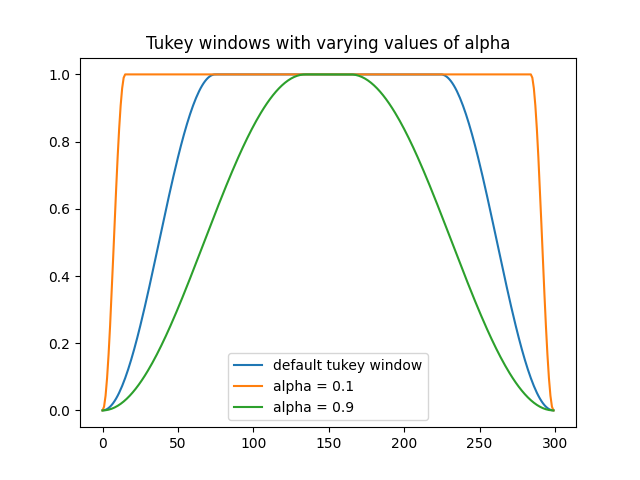

In [14]:
default_tukey_window = tukey(window_half_width * 2)
alpha_01 = tukey(window_half_width * 2, alpha=0.1)
alpha_09 = tukey(window_half_width * 2, alpha=0.9)
plt.figure()
plt.plot(default_tukey_window, label='default tukey window')
plt.plot(alpha_01, label='alpha = 0.1')
plt.plot(alpha_09, label='alpha = 0.9')
plt.title('Tukey windows with varying values of alpha')

plt.legend()
plt.show()

In [15]:
# Apply windows to data
alpha = 0.4

start_index_ref = window_centre_index_ref - window_half_width
end_index_ref = window_centre_index_ref + window_half_width

start_index_sample = window_centre_index_sample - window_half_width
end_index_sample = window_centre_index_sample + window_half_width

# Ensure that the indices are within bounds of the signal
start_index_ref = max(start_index_ref, 0)
end_index_ref = min(end_index_ref, len(signal_ref))

start_index_sample = max(start_index_sample, 0)
end_index_sample = min(end_index_sample, len(signal_sample))


window_size = 2 * window_half_width

tukey_window = tukey(window_size, alpha=alpha)

# Apply window to signal
windowed_signal_ref = np.zeros_like(signal_ref)
windowed_signal_ref[start_index_ref:end_index_ref] = signal_ref[start_index_ref:end_index_ref] * tukey_window

windowed_signal_sample = np.zeros_like(signal_sample)
windowed_signal_sample[start_index_sample:end_index_sample] = signal_sample[start_index_sample:end_index_sample] * tukey_window


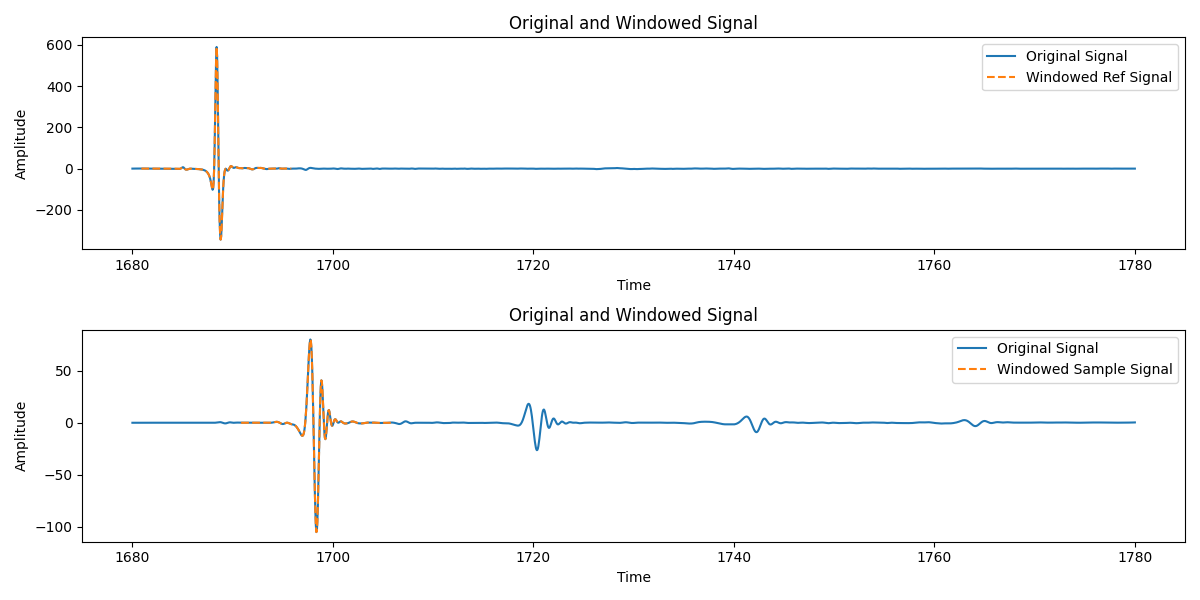

In [16]:
fig2, axs2 = plt.subplots(2, 1, figsize=(12, 6))

axs2[0].plot(time_ref, signal_ref, label='Original Signal')
axs2[0].plot(time_ref[start_index_ref:end_index_ref], windowed_signal_ref[start_index_ref:end_index_ref], label='Windowed Ref Signal', linestyle='--')
axs2[0].set_title("Original and Windowed Signal")
axs2[0].set_xlabel("Time")
axs2[0].set_ylabel("Amplitude")
axs2[0].legend()

axs2[1].plot(time_sample, signal_sample, label='Original Signal')
axs2[1].plot(time_sample[start_index_sample:end_index_sample], windowed_signal_sample[start_index_sample:end_index_sample], label='Windowed Sample Signal', linestyle='--')
axs2[1].set_title("Original and Windowed Signal")
axs2[1].set_xlabel("Time")
axs2[1].set_ylabel("Amplitude")
axs2[1].legend()


plt.tight_layout()
plt.show()



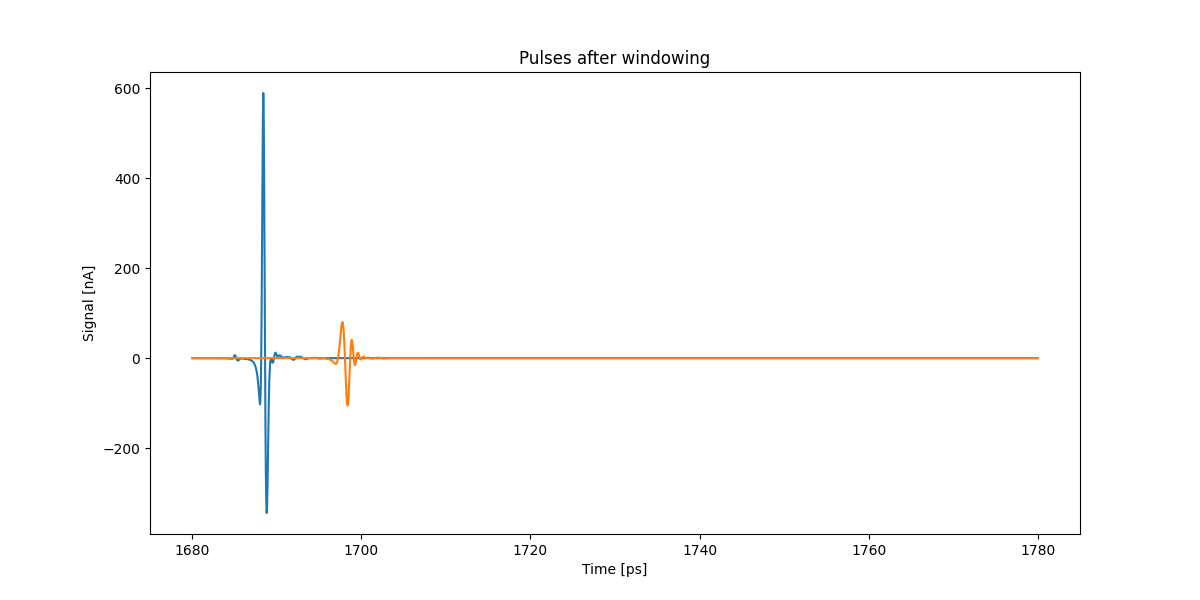

In [17]:
plt.figure(figsize=(12,6))
plt.plot(time_ref, windowed_signal_ref)
plt.plot(time_sample, windowed_signal_sample)
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.title('Pulses after windowing')
plt.show()

In [18]:
# Combine windowed signal data with time values for extractor class

windowed_ref_tab = np.column_stack((time_ref, windowed_signal_ref))
windowed_sample_tab = np.column_stack((time_sample, windowed_signal_sample))

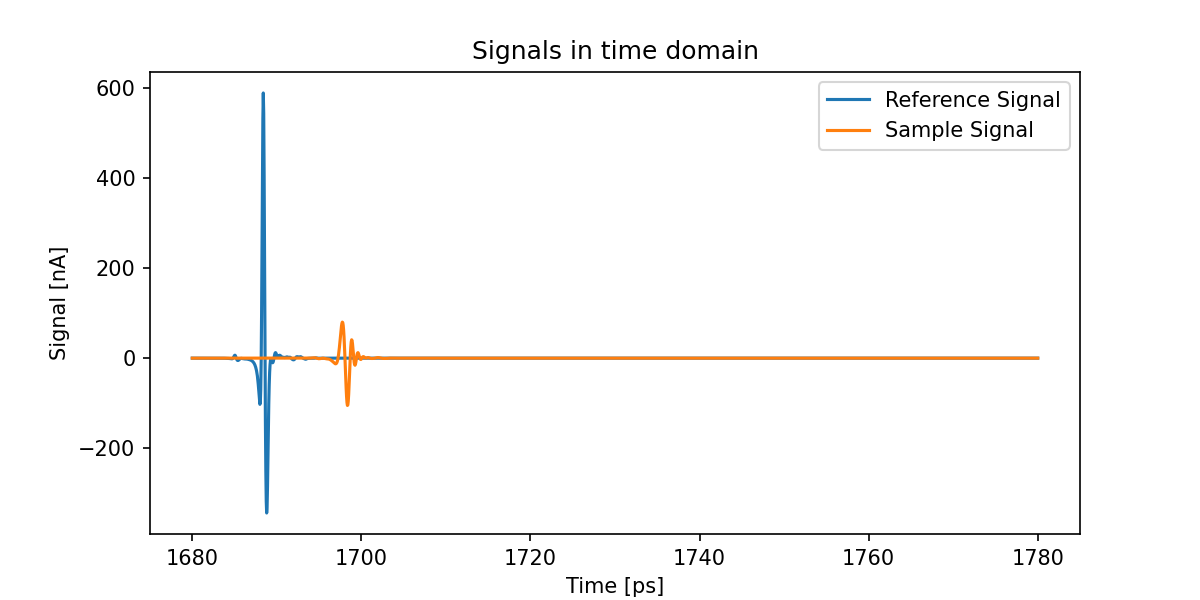

In [19]:
# test windowed functions in Extractor class
windowed_extractor = Extractor(windowed_ref_tab, windowed_sample_tab, thickness=(489 * 1e-6))

windowed_extractor.plot_time_domain()

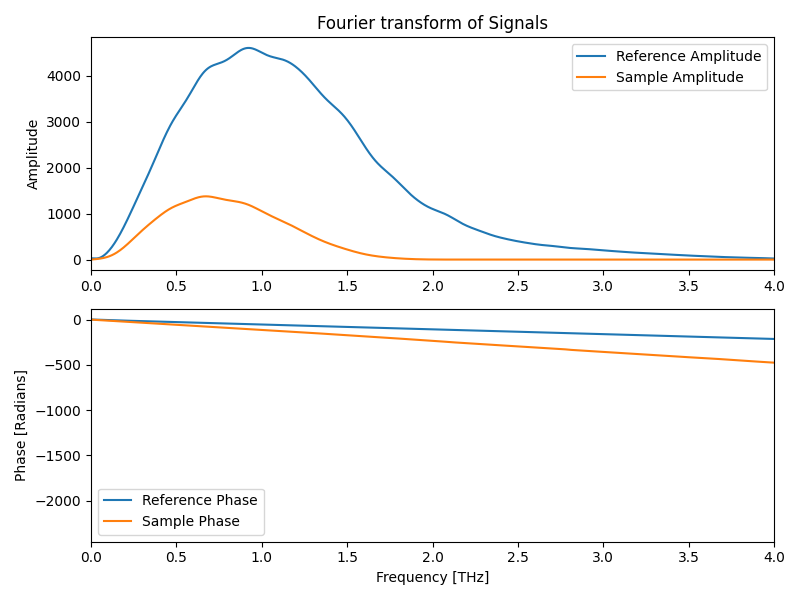

In [20]:
# FT signals 
windowed_extractor.fft_signals()
windowed_extractor.plot_frequency_domain()

/Users/theosmith/Documents/MPhys_YiER_Project/Git_repo/THz-TDS/Extraction/transfer_functions.py:23: RuntimeWarning: overflow encountered in exp
  return (4 * n) / ((n + 1) ** 2) * np.exp(-1j * (n - 1) * w * length/ c)
/Users/theosmith/Documents/MPhys_YiER_Project/Git_repo/THz-TDS/Extraction/transfer_functions.py:23: RuntimeWarning: invalid value encountered in multiply
  return (4 * n) / ((n + 1) ** 2) * np.exp(-1j * (n - 1) * w * length/ c)


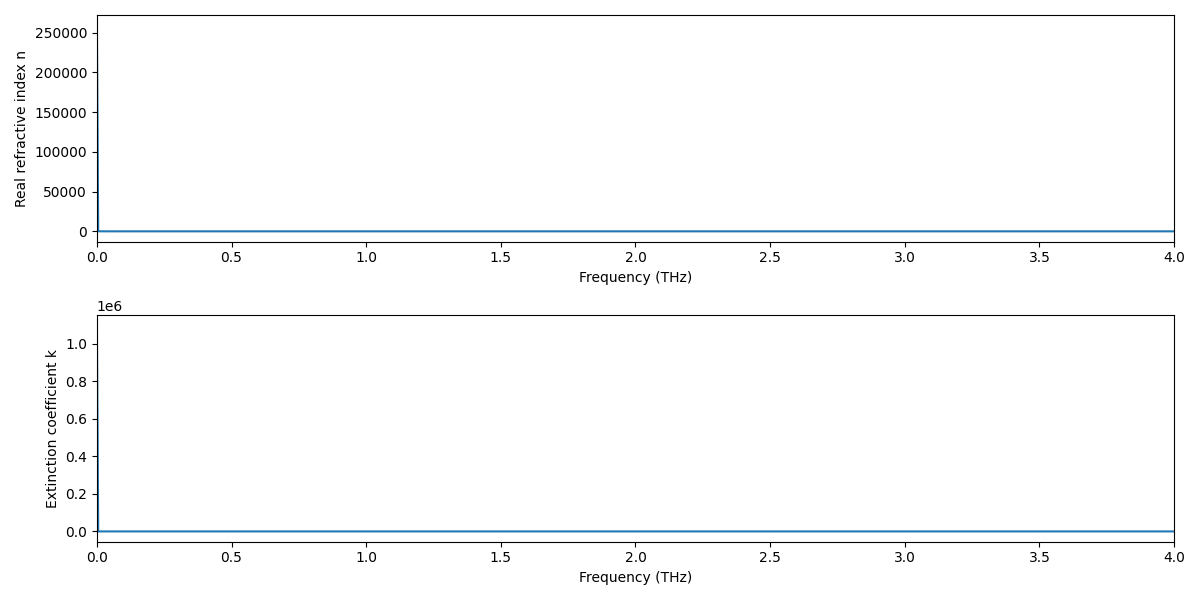

In [21]:
# Extract refractive index with NR method
windowed_extractor.calculate_refractive_index(n_0=6.7 + 1j)
windowed_extractor.plot_refractive_index()

In [22]:
windowed_extractor.get_fft_data()

,interpolated frequency,amplitude_signal_ref,amplitude_signal_sample,phase_signal_ref,phase_signal_sample
0,0.000000,28.037981,0.254587,3.141593,0.000000
1,0.004882,27.851380,1.600414,2.809848,0.848157
2,0.009763,27.313946,3.189213,2.471190,0.365298
3,0.014645,26.498653,4.822857,2.118163,-0.169944
4,0.019526,25.546983,6.515760,1.742564,-0.718041
...,...,...,...,...,...
4091,19.970479,24.697313,8.286833,-1075.761040,-2336.074068
4092,19.975360,25.546983,6.515760,-1076.167252,-2336.626893
4093,19.980242,26.498653,4.822857,-1076.542850,-2337.174990
4094,19.985123,27.313946,3.189213,-1076.895877,-2337.710232


In [23]:
windowed_extractor.get_refractive_index_data()

,real_part,imaginary_part
0,259175.964564,1.097759e+06
1,43.708735,-8.090175e+00
2,23.216751,-2.976820e+00
3,16.624982,-1.070566e+00
4,13.325089,-9.092836e-02
...,...,...
4091,7.157749,-1.214534e-03
4092,7.156961,-2.554362e-03
4093,7.156300,-4.201927e-03
4094,7.155687,-6.368452e-03


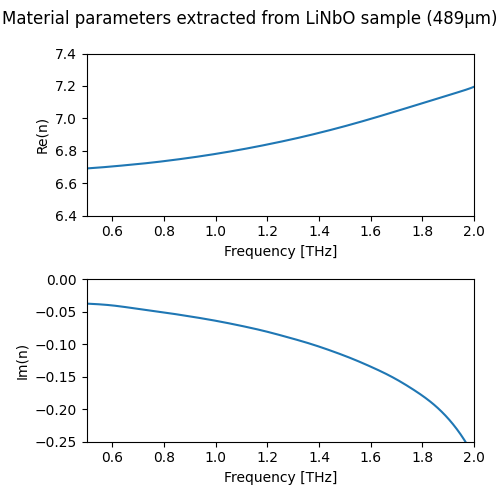

In [24]:
# Pull data from class and plot to compare with reference materials
freqs_THz = windowed_extractor.get_fft_data()['interpolated frequency']
n_extracted_data = windowed_extractor.get_refractive_index_data()



fig3, axs3 = plt.subplots(2,1, figsize=(5,5))

axs3[0].plot(freqs_THz, n_extracted_data['real_part'])
axs3[0].set_xlim([0.5, 2])
axs3[0].set_ylim([6.4, 7.4])
axs3[0].set_xlabel('Frequency [THz]')
axs3[0].set_ylabel('Re(n)')

axs3[1].plot(freqs_THz, n_extracted_data['imaginary_part'])
axs3[1].set_xlim([0.5, 2])
axs3[1].set_ylim([-0.25, 0])
axs3[1].set_xlabel('Frequency [THz]')
axs3[1].set_ylabel('Im(n)')


fig3.suptitle('Material parameters extracted from LiNbO sample (489µm)')
plt.tight_layout()
plt.show()